# Quantum Control via Commutative Pop Opt with Unitary Preserving Pade Approximation for Magnus expansion

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm
from sympy.physics.quantum.dagger import Dagger
from qutip import propagator, Qobj
from qcontrol_polyopt import *

# Constructing a quantum system

Generate a quantum system with the hamiltonian
$\hat{H}(t) = \hat{H}_0 + u(t) \hat{V}$,
where $u(t)$ is a control field.

In [2]:
# Quantum system is taken from https://github.com/q-optimize/c3/blob/master/examples/two_qubits.ipynb

# Drift Hamiltonian 
H0 = np.array([[0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 3.21505101e+10+0.j, 0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 6.23173079e+10+0.j]])

# Normalize the drift Hamiltonian by its maximum.
# This normalization factor can be accounted for by rescaling the time.
H0 /= H0.max()


# Control Hamiltonian
V = np.array([[0.        +0.j, 1.        +0.j, 0.        +0.j],
       [1.        +0.j, 0.        +0.j, 1.41421356+0.j],
       [0.        +0.j, 1.41421356+0.j, 0.        +0.j]])

# Normalize the control Hamiltonian by its maximum.
# This normalization factor can be accounted for by rescaling the control field.
V /= V.max()


## Initialize class for polynomial control optimization

In [3]:
control = QControlPolyOpt(H0=H0, V=V)

# Define test control $u(t)$ and unitary target

In [4]:
t = control.t

np.random.seed(8262021)

x_test = dict(zip(control.x, np.random.uniform(-1, 1, len(control.x))))
u_test = lambdify(t, control.u(t).subs(x_test))

Get the exact propagator using QuTip

In [5]:
U_target = propagator(
    [Qobj(H0), [Qobj(V), str(u_test(t))]], control.T,
)

# Magnus expansion

Check whether the Magnus series converges by verifying that $\int _{0}^{T}\| \hat{A}(s) \|_{2}\,ds<\pi $

In [6]:
assert integrate( control.A(u_test, t).norm(), (t, 0, control.T)).evalf() < np.pi, \
    "Magnus series does not converge"

In [7]:
Omega = control.get_truncated_Magnus_expansion(u_test)
Omega.norm()

1.25460452665120

Get the Magnus propagator

In [8]:
U_magnus = expm(np.array(Omega, dtype=np.complex))

Compare the exact propagator with Magnus

In [9]:
(U_target - U_magnus).norm()

0.001318226889863429

Evaluating Matrix exponent by unitarily preserving the Pade approximation (i.e., the Claye transform)
$$
    \exp \Omega = \frac{1 + \tanh(\Omega/2)}{1 - \tanh(\Omega/2)}, \\
    \tanh(\Omega/2) \approx \Omega/2 - \frac{1}{3}(\Omega/2)^3 
    + \frac{2}{15} (\Omega/2)^5 
     = \Omega/2 \left(1 + (\Omega/2)^2 \left[-\frac{1}{3} +\frac{2}{15} (\Omega/2)^2 \right] \right)
$$

In [10]:
ident = control.ident
approx_tanh = control.approx_tanh.subs(x_test)

U_magnus_pade = (ident + approx_tanh) @ (ident - approx_tanh).inv()
U_magnus_pade = U_magnus_pade.simplify()

In [11]:
(U_target - U_magnus_pade).norm()

0.00217718778141250

In [12]:
(U_magnus - U_magnus_pade).norm()

0.00202747089080841

## Run Optimization

print the value of target polynomial after running optimization

In [13]:
control.get_controls(U_target).obj_poly_val

2.57029154845512e-6

Control pulse found via the polynomial optimization

In [14]:
control.u_opt(t)

-0.0341159244953954*t**2 - 0.0681593515210482*t - 0.2759436141915

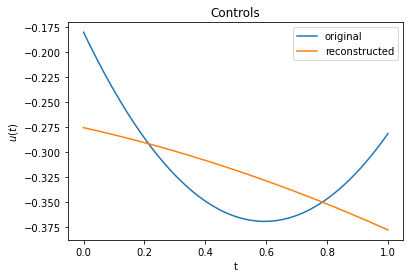

In [15]:
times = np.linspace(0, control.T, 500)

plt.title('Controls')
plt.plot(times, u_test(times), label='original')
plt.plot(times, control.u_opt(times), label='reconstructed')
plt.ylabel('$u(t)$')
plt.xlabel('t')
plt.legend()
plt.show()

Obtain the unitary that the found control synthesized  

In [16]:
U_opt = propagator(
    [Qobj(H0), [Qobj(V), str(control.u_opt(t))]], control.T,
)

Comparing the synthesized and target unitaries

In [17]:
(U_target - U_opt).norm(norm='fro')

0.0013445642675614905